# scCODA - Compositional analysis of single-cell data



This notebook serves as a tutorial for using the *scCODA* package ([Büttner, Ostner et al., 2020](https://www.biorxiv.org/content/10.1101/2020.12.14.422688v2)) to analyze changes in cell composition data.

The package is intended to be used with cell composition from single-cell RNA-seq experiments, however there are no technical
restrictions that prevent the use of data from other sources.

The data we use in the following example comes from [Haber et al., 2017](https://www.nature.com/articles/nature24489).
It contains samples from the small intestinal epithelium of mice with different conditions.

This tutorial is designed to be executed on a standard computer (any operating system) in a Python environment with scCODA, Jupyter notebook and all their dependencies installed.
Running the tutorial takes about 1.5 minutes on a 2020 Apple MacBook Pro (16GB RAM).


In [1]:
# Setup
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import pickle as pkl

from sccoda.util import comp_ana as mod
from sccoda.util import cell_composition_data as dat
from sccoda.util import data_visualization as viz



### Data preparation

In [2]:
# Load data

cell_counts = pd.read_csv("../data/haber_counts.csv")

print(cell_counts)

            Mouse  Endocrine  Enterocyte  Enterocyte.Progenitor  Goblet  Stem  \
0       Control_1         36          59                    136      36   239   
1       Control_2          5          46                     23      20    50   
2       Control_3         45          98                    188     124   250   
3       Control_4         26         221                    198      36   131   
4  H.poly.Day10_1         42          71                    203     147   271   
5  H.poly.Day10_2         40          57                    383     170   321   
6   H.poly.Day3_1         52          75                    347      66   323   
7   H.poly.Day3_2         65         126                    115      33    65   
8          Salm_1         37         332                    113      59    90   
9          Salm_2         32         373                    116      67   117   

    TA  TA.Early  Tuft  
0  125       191    18  
1   11        40     5  
2  155       365    33  
3  130  

Looking at the data, we see that we have 4 control samples, and 3 conditions with 2 samples each. 
To use the models in *scCODA*, we first have to convert the data into an [anndata](https://github.com/theislab/anndata) object.
This can be done easily with the `sccoda.util.cell_composition_data` module.
The resulting object separates our data components: Cell counts are stored in `data.X`, covariates in `data.obs`.

In [3]:
# Convert data to anndata object
data_all = dat.from_pandas(cell_counts, covariate_columns=["Mouse"])

# Extract condition from mouse name and add it as an extra column to the covariates
data_all.obs["Condition"] = data_all.obs["Mouse"].str.replace(r"_[0-9]", "")
print(data_all)

AnnData object with n_obs × n_vars = 10 × 8
    obs: 'Mouse', 'Condition'


For our first example, we want to look at how the Salmonella infection influences the cell composition.
Therefore, we subset our data.

In [4]:

# Select control and salmonella data
data_salm = data_all[data_all.obs["Condition"].isin(["Control", "Salm"])]
print(data_salm.obs)


       Mouse Condition
0  Control_1   Control
1  Control_2   Control
2  Control_3   Control
3  Control_4   Control
8     Salm_1      Salm
9     Salm_2      Salm


Plotting the data, we can see that there is a large increase of Enterocytes in the infected sampes, while most other cell types slightly decrease.
Since scRNA-seq experiments are limited in the number of cells per sample, the count data is compositional, which leads to negative correlations between the cell types.
Thus, the slight decreases in many cell types might be fully caused by the increase in Enterocytes.

<AxesSubplot:xlabel='Cell type', ylabel='Proportion'>

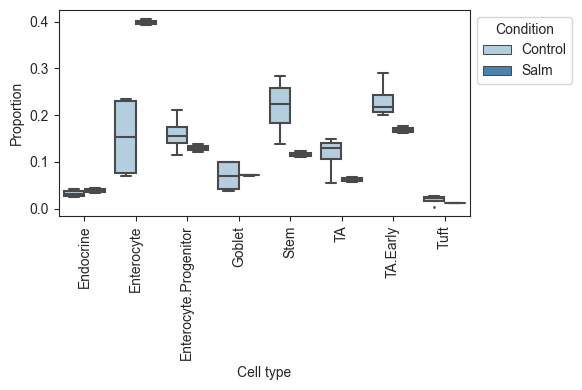

In [5]:
viz.boxplots(data_salm, feature_name="Condition")

*Note that the use of* anndata *in* scCODA *is different from the use in scRNA-seq pipelines, e.g.* scanpy.
*To convert* scanpy *objects to a scCODA dataset, have a look at `dat.from_scanpy.*

### Model setup and inference

We can now create the model and run inference on it. Creating a `sccoda.util.comp_ana.CompositionalAnalysis` class object
sets up the compositional model and prepares everxthing for parameter inference. It needs these informations:

- The data object from above.

- The `formula` parameter. It specifies how the covariates are used in the model.
It can process R-style formulas via the [patsy](https://patsy.readthedocs.io/en/latest/) package, e.g. `formula="Cov1 + Cov2 + Cov3"`.
Here, we simply use the "Condition" covariate of our dataset

- The `reference_cell_type` parameter is used to specify a cell type that is believed to be unchanged by the covariates in `formula`.
This is necessary, because compositional analysis must always be performed relative to a reference (See [Büttner, Ostner et al., 2020](https://www.biorxiv.org/content/10.1101/2020.12.14.422688v2) for a more thorough explanation).
If no knowledge about such a cell type exists prior to the analysis, taking a cell type that has a nearly constant relative abundance over all samples is often a good choice.
It is also possible to let scCODA find a suited reference cell type by using `reference_cell_type="automatic"`.
Here, we take Goblet cells as the reference.

In [6]:
model_salm = mod.CompositionalAnalysis(data_salm, formula="Condition", reference_cell_type="Goblet")

HMC sampling is then initiated by calling `model.sample_hmc()`, which produces a `sccoda.util.result_classes.CAResult` object.

In [7]:
# Run MCMC
sim_results = model_salm.sample_hmc()

MCMC sampling finished. (54.899 sec)
Acceptance rate: 66.4%


### Result interpretation

Calling `summary()` on the results object, we can see the most relevant information for further analysis:

In [8]:
sim_results.summary()

Compositional Analysis summary:

Data: 6 samples, 8 cell types
Reference index: 3
Formula: Condition

Intercepts:
                       Final Parameter  Expected Sample
Cell Type                                              
Endocrine                        1.063        33.595902
Enterocyte                       2.299       115.631001
Enterocyte.Progenitor            2.498       141.090863
Goblet                           1.744        66.380550
Stem                             2.678       168.916430
TA                               2.080        92.888895
TA.Early                         2.843       199.218876
Tuft                             0.398        17.277483


Effects:
                                         Final Parameter  Expected Sample  \
Covariate         Cell Type                                                 
Condition[T.Salm] Endocrine                     0.000000        23.493672   
                  Enterocyte                    1.412235       331.944025   
       

**Model properties**

First, the summary shows an overview over the model properties: 
* Number of samples/cell types
* The reference cell type.
* The formula used

The model has two types of parameters that are relevant for analysis - intercepts and effects. 
These can be interpreted like in a standard regression model:
Intercepts show how the cell types are distributed without any active covariates, effects show ho the covariates influence the cell types.

**Intercepts**

The first column of the intercept summary shows the parameters determined by the MCMC inference.

The "Expected sample" column gives some context to the numerical values. 
If we had a new sample (with no active covariates) with a total number of cells equal to the mean sampling depth of the dataset,
then this distribution over the cell types would be most likely.

**Effects**

For the effect summary, the first column again shows the inferred parameters for all combinations of covariates and cell types.
Most important is the distinctions between zero and non-zero entries
A value of zero means that no statistically credible effect was detected.
For a value other than zero, a credible change was detected. A positive sign indicates an increase, a negative sign a decrease in abundance.

Since the numerical values of the "Final parameter" columns are not straightforward to interpret, the "Expected sample" and "log2-fold change" columns give us an idea on the magnitude of the change.
The expected sample is calculated for each covariate separately (covariate value = 1, all other covariates = 0), with the same method as for the intercepts.
The log-fold change is then calculated between this expected sample and the expected sample with no active covariates from the intercept section.
Since the data is compositional, cell types for which no credible change was detected, are expected to change in abundance as well.

**Interpretation**

In the salmonella case, we see only a credible increase of Enterocytes, while all other cell types are unaffected by the disease.
The log-fold change of Enterocytes between control and infected samples with the same total cell count lies at about 1.54.

We can also easily filter out all credible effects:

In [9]:
print(sim_results.credible_effects())

Covariate          Cell Type            
Condition[T.Salm]  Endocrine                False
                   Enterocyte                True
                   Enterocyte.Progenitor    False
                   Goblet                   False
                   Stem                     False
                   TA                       False
                   TA.Early                 False
                   Tuft                     False
Name: Inclusion probability, dtype: bool


### Saving results

The compositional analysis results can be saved as a pickle object via `results.save(<path_to_file>)`.

In [10]:
# saving
path = "test"
sim_results.save(path)

# loading
with open(path, "rb") as f:
    sim_results_2 = pkl.load(f)
    
sim_results_2.summary()

Compositional Analysis summary:

Data: 6 samples, 8 cell types
Reference index: 3
Formula: Condition

Intercepts:
                       Final Parameter  Expected Sample
Cell Type                                              
Endocrine                        1.063        33.595902
Enterocyte                       2.299       115.631001
Enterocyte.Progenitor            2.498       141.090863
Goblet                           1.744        66.380550
Stem                             2.678       168.916430
TA                               2.080        92.888895
TA.Early                         2.843       199.218876
Tuft                             0.398        17.277483


Effects:
                                         Final Parameter  Expected Sample  \
Covariate         Cell Type                                                 
Condition[T.Salm] Endocrine                     0.000000        23.493672   
                  Enterocyte                    1.412235       331.944025   
       